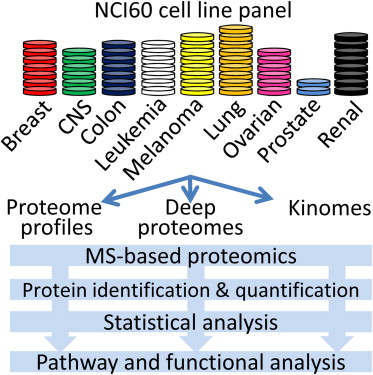

# NCI60 Data Example

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans as KM
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.cluster import hierarchy

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-white')

from scipy.cluster.hierarchy import ward, fcluster
from scipy.spatial.distance import pdist

Unsupervised techniques are often used in the analysis of genomic data. In particular, PCA and hierarchical clustering are popular tools. We illustrate these techniques on the `NCI60` cancer cell line microarray data, which consists of 6,830 gene expression measurements on 64 cancer cell lines.

In [2]:
# In R, I exported the two elements of this ISLR dataset to csv files.
# There is one file for the features and another file for the classes/types.

nci_labs=pd.read_csv('nci_labs.csv')
nci_data=pd.read_csv('nci_data.csv')

nci_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Columns: 6830 entries, v1 to v6830
dtypes: float64(6830)
memory usage: 3.3 MB


In [3]:
X  = pd.DataFrame(StandardScaler().fit_transform(nci_data),index=nci_labs.values, columns=nci_data.columns)

Each cell line is labeled with a cancer type, given in `nci_labs`. We do not make use of the cancer types in performing PCA and clustering, as these are unsupervised techniques. But after performing PCA and clustering, we will check to see the extent to which these cancer types agree with the results of these unsupervised techniques.

The data has 64 rows and 6,830 columns

In [4]:
X.shape

(64, 6830)

We begin by examining the cancer types for the cell lines.

In [5]:
nci_labs.head().T

,0,1,2,3,4
value,CNS,CNS,CNS,RENAL,BREAST


In [6]:
nci_labs.value_counts()

value      
RENAL          9
NSCLC          9
MELANOMA       8
COLON          7
BREAST         7
OVARIAN        6
LEUKEMIA       6
CNS            5
PROSTATE       2
UNKNOWN        1
MCF7D-repro    1
MCF7A-repro    1
K562B-repro    1
K562A-repro    1
dtype: int64

## PCA on the NCI60 Data

We first perform PCA on the data after scaling the variables (genes) to have standard deviation one, although one could reasonably argue that it is better not to scale the genes.

In [7]:
pca = PCA()
prin_plot = pd.DataFrame(data = pca.fit_transform(nci_data))

We now plot the first few principal component score vectors, in order to visualize the data. The observations (cell lines) corresponding to a given cancer type will be plotted in the same color, so that we can see to what extent the observations within a cancer type are similar to each other. We first `factorize` and `cmap`to assign a distinct color to each element of a numeric vector. The values will be used to assign a color to each of the 64 cell lines, based on the cancer type to which it corresponds.

Note that the `scatter()` function takes `c` and `cmap` as its arguments. This is where we specify the `hsv` color map and the cancer type labels as the marker colors, and returns a vector containing that number of distinct colors. We now can
plot the principal component score vectors.

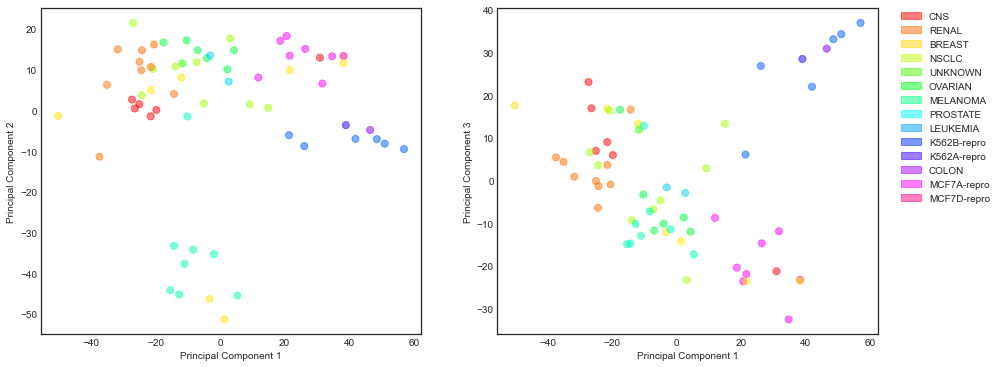

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

color_idx = pd.factorize(nci_labs.value)[0]
cmap = plt.cm.hsv

# Left plot
ax1.scatter(prin_plot.iloc[:,0], -prin_plot.iloc[:,1], c=color_idx, cmap=cmap, alpha=0.5, s=50)
ax1.set_ylabel('Principal Component 2')

# Right plot
ax2.scatter(prin_plot.iloc[:,0], prin_plot.iloc[:,2], c=color_idx, cmap=cmap, alpha=0.5, s=50)
ax2.set_ylabel('Principal Component 3')

# Custom legend for the classes (y) since we do not create scatter plots per class (which could have their own labels).
handles = []
labels = pd.factorize(nci_labs.value.unique())
norm = mpl.colors.Normalize(vmin=0.0, vmax=14.0)

for i, v in zip(labels[0], labels[1]):
    handles.append(mpl.patches.Patch(color=cmap(norm(i)), label=v, alpha=0.5))

ax2.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# xlabel for both plots
for ax in fig.axes:
    ax.set_xlabel('Principal Component 1')

*__FIGURE 1.__ Projections of the NCI60 cancer cell lines onto the first three principal components (in other words, the scores for the first three principal components). On the whole, observations belonging to a single cancer type tend to lie near each other in this low-dimensional space. It would not have been possible to visualize the data without using a  dimension reduction method such as PCA, since based on the full data set there are .{6,830\choose 2} possible scatterplots, none of which would have been particularly informative.*

The resulting plots are shown in Figure 1. On the whole, cell lines corresponding to a single cancer type do tend to have similar values on the first few principal component score vectors. This indicates that cell lines from the same cancer type tend to have pretty similar gene expression levels.

We can obtain a the proportion of variance explained (PVE) of the first few principal components using the `explained_variance_ratio_` method for a prcomp object:

In [9]:
pd.DataFrame([prin_plot.iloc[:,:20].std(axis=0, ddof=0).to_numpy(),
              pca.explained_variance_ratio_[:20],
              np.cumsum(pca.explained_variance_ratio_[:20])],
             index=['Standard Deviation', 'Proportion of Variance', 'Cumulative Proportion'],
             columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5','PC6', 'PC7', 'PC8', 'PC9', 'PC10',
                     'PC11', 'PC12', 'PC13', 'PC14', 'PC15','PC16', 'PC17', 'PC18', 'PC19', 'PC20']).T

,Standard Deviation,Proportion of Variance,Cumulative Proportion
PC1,24.966409,0.148929,0.148929
PC2,18.639027,0.083007,0.231936
PC3,16.599553,0.065836,0.297772
PC4,13.424692,0.043060,0.340832
PC5,12.688644,0.038468,0.379300
PC6,12.114749,0.035067,0.414367
PC7,10.971667,0.028762,0.443129
PC8,10.859073,0.028174,0.471303
PC9,10.508326,0.026384,0.497687
PC10,9.501463,0.021570,0.519257


Using the `plot()` function, we can also plot the variance explained by the first few principal components.

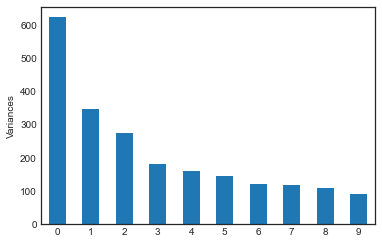

In [10]:
prin_plot.iloc[:,:10].var(axis=0, ddof=0).plot(kind='bar', rot=0)
plt.ylabel('Variances');

Note that the height of each bar in the bar plot is given by the corresponding element of `var`. However, it is more informative to plot the PVE of each principal component (i.e. a scree plot) and the cumulative PVE of each principal component. This can be done with just a little work.

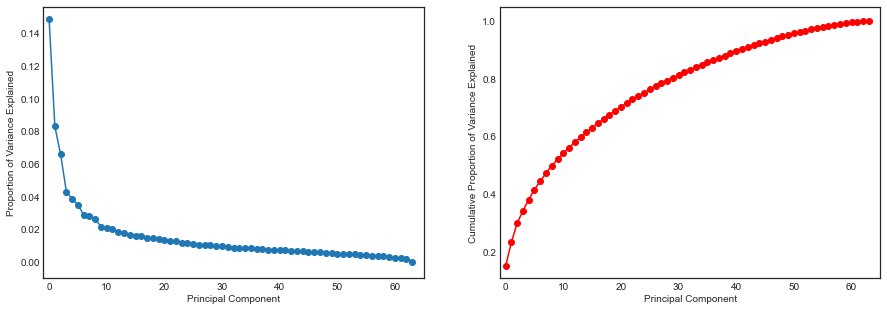

In [11]:
fig , (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

# Left plot
ax1.plot(pca.explained_variance_ratio_, '-o')
ax1.set_ylabel('Proportion of Variance Explained')
ax1.set_ylim(ymin=-0.01)

# Right plot
ax2.plot(np.cumsum(pca.explained_variance_ratio_), '-ro')
ax2.set_ylabel('Cumulative Proportion of Variance Explained')
ax2.set_ylim(ymax=1.05)

for ax in fig.axes:
    ax.set_xlabel('Principal Component')
    ax.set_xlim(-1,65)

*__FIGURE 2.__ The PVE of the principal components of the NCI60 cancer cell line microarray data set. Left: the PVE of each principal component is shown. Right: the cumulative PVE of the principal components is shown. Together, all principal components explain 100 % of the variance.*

The resulting plots are shown in Figure 2. We see that together, the first seven principal components explain around 40% of the variance in the data. This is not a huge amount of the variance. However, looking at the scree plot, we see that while each of the first seven principal components explain a substantial amount of variance, there is a marked decrease in the variance explained by further principal components. That is, there is an elbow in the plot after approximately the seventh principal component. This suggests that there may be little benefit to examining more than seven or so principal components (though even examining seven principal components may be difficult).

## Clustering the Observations of the NCI60 Data

We now proceed to hierarchically cluster the cell lines in the NCI60 data, with the goal of finding out whether or not the observations cluster into distinct types of cancer. To begin, we standardize the variables to have mean zero and standard deviation one. As mentioned earlier, this step is optional and should be performed only if we want each gene to be on the
same scale.

In [12]:
X  = pd.DataFrame(StandardScaler().fit_transform(nci_data),index=nci_labs.values, columns=nci_data.columns)

We now perform hierarchical clustering of the observations using complete, single, and average linkage. Euclidean distance is used as the dissimilarity measure.

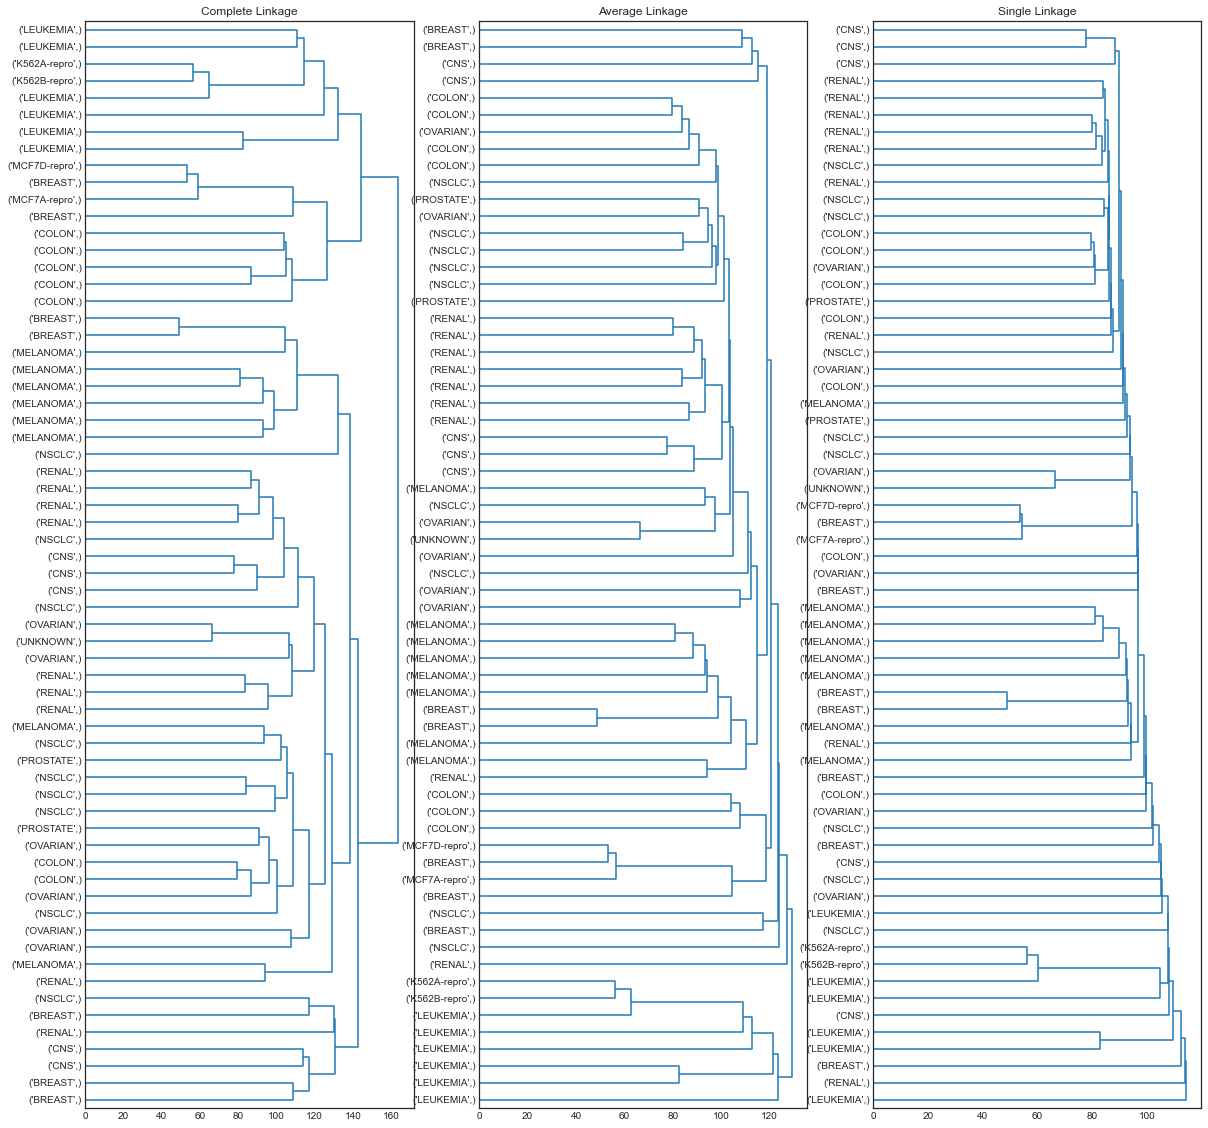

In [13]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,20))

for linkage, cluster, ax in zip([hierarchy.complete(X), hierarchy.average(X), hierarchy.single(X)],
                                ['c1','c2','c3'],
                                [ax1,ax2,ax3]):
    cluster = hierarchy.dendrogram(linkage, labels=X.index, orientation='right', color_threshold=0, leaf_font_size=10, ax=ax)

ax1.set_title('Complete Linkage')
ax2.set_title('Average Linkage')
ax3.set_title('Single Linkage');

The results are shown in the figure above. We see that the choice of linkage certainly does affect the results obtained. Typically, single linkage will tend to yield trailing clusters: very large clusters onto which individual observations attach one-by-one. On the other hand, complete and average linkage tend to yield more balanced, attractive clusters. For this reason, complete and average linkage are generally preferred to single linkage. Clearly cell lines within a single cancer type do tend to cluster together, although the clustering is not perfect. We will use complete linkage hierarchical clustering for the analysis that follows. 

We can cut the dendrogram at the height that will yield a particular number of clusters, say four:

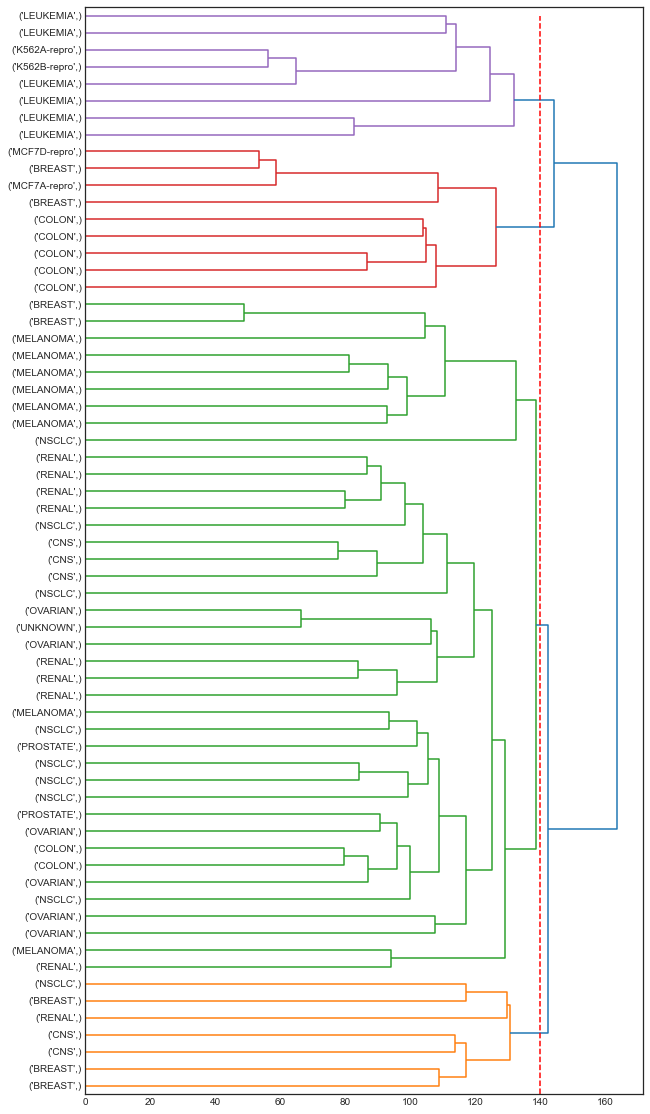

In [14]:
plt.figure(figsize=(10,20))
cut4 = hierarchy.dendrogram(hierarchy.complete(X),
                            labels=X.index, orientation='right', color_threshold=140, leaf_font_size=10)
plt.vlines(140,0,plt.gca().yaxis.get_data_interval()[1], colors='r', linestyles='dashed');

There are some clear patterns. All the leukemia cell lines fall in cluster 3, while the breast cancer cell lines are spread out over three different clusters. We've plot the cut on the dendrogram that produces these four clusters.

The `vlines()` function draws a straight line on top of any existing plot in `Pyplot`. The argument `140` plots a horizontal line at height 140 on the dendrogram; this is the height that results in four distinct clusters. 

We claimed earlier that K-means clustering and hierarchical clustering with the dendrogram cut to obtain the same number of clusters can yield very different results. How do these NCI60 hierarchical clustering results compare to what we get if we perform K-means clustering with *K* = 4?

In [15]:
np.random.seed(4) # this isn't the same as the seed in R mentioned in book. Nonetheless, I use the same seed here
km_out = KM(n_clusters=4, n_init=50).fit(X)
km_labels = km_out.labels_
km_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [16]:
hc_complete = hierarchy.linkage(y = X, method="complete")#, metric='euclidean') 
cut_tree(hc_complete, n_clusters = 4).T

array([[0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 3, 0,
        3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [17]:
pd.crosstab(cut_tree(hc_complete, n_clusters = 4).flatten(),km_labels, rownames=["Hierarchical"], colnames=['K-means'])

K-means,0,1,2,3
Hierarchical,,,,
0,9,16,0,15
1,0,7,0,0
2,0,0,8,0
3,0,0,0,9


We see that the four clusters obtained using hierarchical clustering and Kmeans clustering are somewhat different. Cluster 4 in *K*-means clustering is identical to cluster 3 in hierarchical clustering. However, the other clusters differ: for instance, cluster 2 in *K*-means clustering contains a portion of the observations assigned to cluster 1 by hierarchical clustering, as well as a lot of the observations assigned to cluster 4 by *K*-Means clustering.